<a href="https://colab.research.google.com/github/RazerRaymond/Pricing-Simulations/blob/main/asset_price_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

date_parser = lambda c: pd.to_datetime(c, format='%Y-%m-%d', errors='coerce')
df = pd.read_csv('https://raw.githubusercontent.com/RazerRaymond/ProblemData/main/BAC_data.csv', sep=',', parse_dates=['date'], date_parser=date_parser)
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,11.86,11.90,11.72,11.760,145217221,BAC
1,2013-02-11,11.73,11.90,11.67,11.860,103499848,BAC
2,2013-02-12,11.87,12.34,11.78,12.245,231771561,BAC
3,2013-02-13,12.35,12.42,12.05,12.170,192478919,BAC
4,2013-02-14,12.09,12.27,12.07,12.130,143901737,BAC


Text(0.5, 1.0, 'ABBV Daily Close Price')

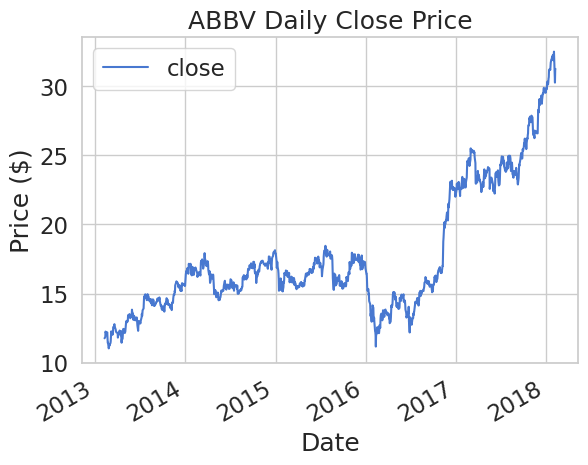

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(x='date', y='close');
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('ABBV Daily Close Price')

In [ ]:
scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [ ]:
seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    print(x_train.shape)
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test
g
x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.9)
x_test.shape

(1080, 59, 1)


(120, 59, 1)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1
# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
))

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
)

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [ ]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/20
61/61 [==============================] - 32s 278ms/step - loss: 0.0075 - val_loss: 0.0245
Epoch 2/20
61/61 [==============================] - 14s 237ms/step - loss: 0.0072 - val_loss: 0.0280
Epoch 3/20
61/61 [==============================] - 14s 234ms/step - loss: 0.0120 - val_loss: 0.0014
Epoch 4/20
61/61 [==============================] - 16s 253ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 5/20
61/61 [==============================] - 15s 238ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 6/20
61/61 [==============================] - 16s 263ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 7/20
61/61 [==============================] - 15s 241ms/step - loss: 7.7124e-04 - val_loss: 0.0019
Epoch 8/20
61/61 [==============================] - 15s 247ms/step - loss: 7.5171e-04 - val_loss: 0.0028
Epoch 9/20
61/61 [==============================] - 14s 224ms/step - loss: 7.4214e-04 - val_loss: 0.0019
Epoch 10/20
61/61 [==============================] - 14s 232ms/step - loss: 6.9

In [ ]:
x_test

array([[[0.57428971],
        [0.56916628],
        [0.56870051],
        ...,
        [0.62366092],
        [0.62598975],
        [0.6129483 ]],

       [[0.56916628],
        [0.56870051],
        [0.55333023],
        ...,
        [0.62598975],
        [0.6129483 ],
        [0.58733116]],

       [[0.56870051],
        [0.55333023],
        [0.53004192],
        ...,
        [0.6129483 ],
        [0.58733116],
        [0.58639963]],

       ...,

       [[0.73404751],
        [0.72007452],
        [0.72100605],
        ...,
        [0.97671169],
        [1.        ],
        [0.97438286]],

       [[0.72007452],
        [0.72100605],
        [0.71588263],
        ...,
        [1.        ],
        [0.97438286],
        [0.89566837]],

       [[0.72100605],
        [0.71588263],
        [0.70843037],
        ...,
        [0.97438286],
        [0.89566837],
        [0.9394504 ]]])

4/4 [==============================] - 1s 194ms/step


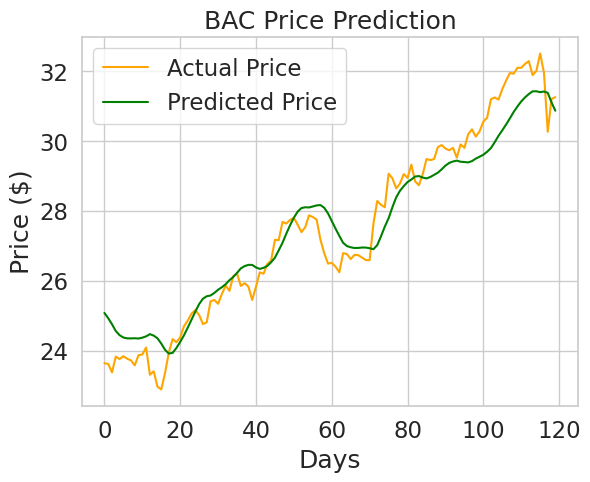

In [10]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')

plt.title('BAC Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')

plt.show();

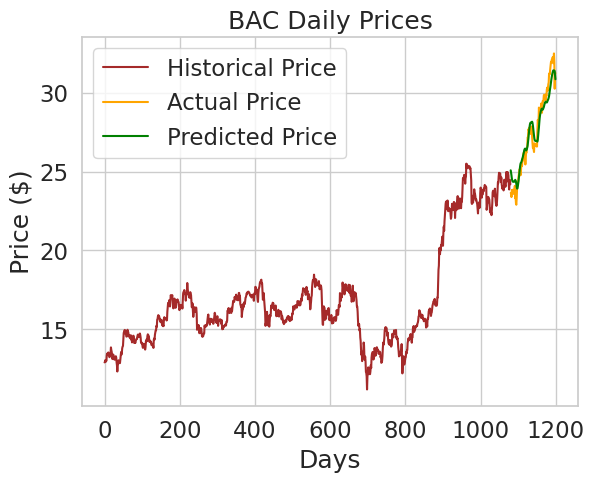

In [11]:
# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('BAC Daily Prices')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show();